In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, friedmanchisquare, wilcoxon, f_oneway, ttest_rel
from itertools import combinations
from statsmodels.stats.multitest import multipletests

"""
Statistical testing pipeline
============================

We want to compare **datasets** using model performances as repeated measures.

Setup:
- Each (Method × Dataset) pair is run with 5 random seeds → repeated measures (paired data).
- Scores from the seeds are used directly in the tests (no averaging).
- This allows us to compare datasets while accounting for variance across seeds.

Testing procedure:
1. **Check normality**
   - For each dataset–method, test whether the distribution of scores across seeds is roughly normal.
   - Shapiro–Wilk test:
     - p > 0.05 → assume normal distribution (parametric tests).
     - p ≤ 0.05 → reject normality (non-parametric tests).

2. **Global comparison** (more than 2 datasets)
   - If normal → one-way repeated-measures ANOVA (within-subjects).
     - H0: all dataset means are equal.
   - If not normal → Friedman test.
     - H0: distributions across datasets are the same.

3. **Post-hoc pairwise comparisons**
   - If ANOVA (parametric): paired t-tests between datasets.
   - If Friedman (non-parametric): Wilcoxon signed-rank tests.

4. **Multiple comparisons correction**
   - Holm–Bonferroni correction applied to all pairwise p-values
     to control inflation of Type I error.

Interpretation:
- The **global test** tells us if at least one dataset differs.
- The **pairwise tests** (with correction) identify *which* datasets differ.
"""

# ----------------------
# Step 1: Load the raw seed data from Excel
# ----------------------
file_path = "../../12_results/summary/tasd.xlsx"
# file_path = "../../12_results/summary/acsa.xlsx"
df = pd.read_excel(file_path)

# ----------------------
# Step 2: Define metrics to analyze
# ----------------------
# metrics = ["Accuracy", "Micro-F1", "Macro-F1"]
metrics = ["Micro-F1"]
# ----------------------
# Step 3: Iterate over metrics and methods
# ----------------------
for metric in metrics:
    print(f"\n##############################")
    print(f"### Metric: {metric}")
    print(f"##############################")

    df_metric = df.dropna(subset=[metric])  # drop missing entries
    df_metric["Micro-F1"] = df_metric["Micro-F1"]*100  # for potential filtering
    print(df_metric.head())
    methods = df_metric["Model"].unique()

    for method in methods:
        print(f"\n===== Method: {method} =====")

        subset = df_metric[df_metric["Model"] == method]

        # Pivot to datasets × seeds
        pivot = subset.pivot(index="Seed", columns="Dataset", values=metric)

        # Drop datasets without enough values
        pivot = pivot.dropna(axis=1)
        datasets = pivot.columns.tolist()

        if len(datasets) < 2:
            print("Not enough datasets with valid results, skipping.")
            continue

        scores_matrix = pivot.values.T  # shape: datasets × seeds

        # ----------------------
        # Normality test across all datasets
        # ----------------------
        all_values = pivot.values.flatten()
        stat, p_normality = shapiro(all_values)
        print(f"Shapiro-Wilk normality: W={stat:.4f}, p={p_normality:.4f}")

        # ----------------------
        # Statistical testing
        # ----------------------
        if p_normality > 0.05:
            print("Using parametric tests (Repeated-measures ANOVA + paired t-tests)")

            stat, p_anova = f_oneway(*scores_matrix)
            print(f"ANOVA p={p_anova:.4f}")

            # Pairwise t-tests
            pairs = list(combinations(range(len(datasets)), 2))
            p_values, labels = [], []
            for i, j in pairs:
                stat, p = ttest_rel(scores_matrix[i], scores_matrix[j])
                p_values.append(p)
                labels.append(f"{datasets[i]} vs {datasets[j]}")

        else:
            print("Using non-parametric tests (Friedman + Wilcoxon)")

            stat, p_friedman = friedmanchisquare(*scores_matrix)
            print(f"Friedman p={p_friedman:.4f}")

            pairs = list(combinations(range(len(datasets)), 2))
            p_values, labels = [], []
            for i, j in pairs:
                stat, p = wilcoxon(scores_matrix[i], scores_matrix[j])
                p_values.append(p)
                labels.append(f"{datasets[i]} vs {datasets[j]}")

        # ----------------------
        # Holm-Bonferroni correction
        # ----------------------
        reject, p_corrected, _, _ = multipletests(p_values, method="holm")

        print("Pairwise comparisons (Holm-Bonferroni corrected):")
        for lbl, raw_p, adj_p, sig in zip(labels, p_values, p_corrected, reject):
            print(f"{lbl}: raw p={raw_p:.4f}, adj p={adj_p:.4f}, significant={sig}")



##############################
### Metric: Micro-F1
##############################
        Model  Dataset  Seed  Micro-F1  Macro-F1  Accuracy
0  Paraphrase  Experts     5     63.01    0.5784    0.4600
1  Paraphrase  Experts    10     61.38    0.5564    0.4428
2  Paraphrase  Experts    15     61.90    0.5604    0.4482
3  Paraphrase  Experts    20     60.35    0.5514    0.4321
4  Paraphrase  Experts    25     61.63    0.5654    0.4454

===== Method: Paraphrase =====
Shapiro-Wilk normality: W=0.9601, p=0.5468
Using parametric tests (Repeated-measures ANOVA + paired t-tests)
ANOVA p=0.0000
Pairwise comparisons (Holm-Bonferroni corrected):
Crowd vs Experts: raw p=0.0001, adj p=0.0007, significant=True
Crowd vs LLM: raw p=0.0013, adj p=0.0051, significant=True
Crowd vs Students: raw p=0.0037, adj p=0.0074, significant=True
Experts vs LLM: raw p=0.0022, adj p=0.0066, significant=True
Experts vs Students: raw p=0.0005, adj p=0.0023, significant=True
LLM vs Students: raw p=0.9602, adj p=0.9602

## Visualize

In [ ]:
task = "acsa"
file_path = f"../../12_results/summary/{task}.xlsx"
df = pd.read_excel(file_path)
df

,Model,Dataset,Seed,Micro-F1,Macro-F1,Accuracy
40,LLM-FS,Experts,5,0.6262,0.5812,0.4558
41,LLM-FS,Experts,10,0.6426,0.5991,0.4735
42,LLM-FS,Experts,15,0.6320,0.5800,0.4620
43,LLM-FS,Experts,20,0.6329,0.5864,0.4629
44,LLM-FS,Experts,25,0.6353,0.5904,0.4655
45,LLM-FS,LLM,5,0.6540,0.6209,0.4859
46,LLM-FS,LLM,10,0.6606,0.6276,0.4932
47,LLM-FS,LLM,15,0.6565,0.6252,0.4886
48,LLM-FS,LLM,20,0.6614,0.6265,0.4941
49,LLM-FS,LLM,25,0.6463,0.6147,0.4775


C:\Users\nikla\AppData\Local\Temp\ipykernel_7596\1086704462.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


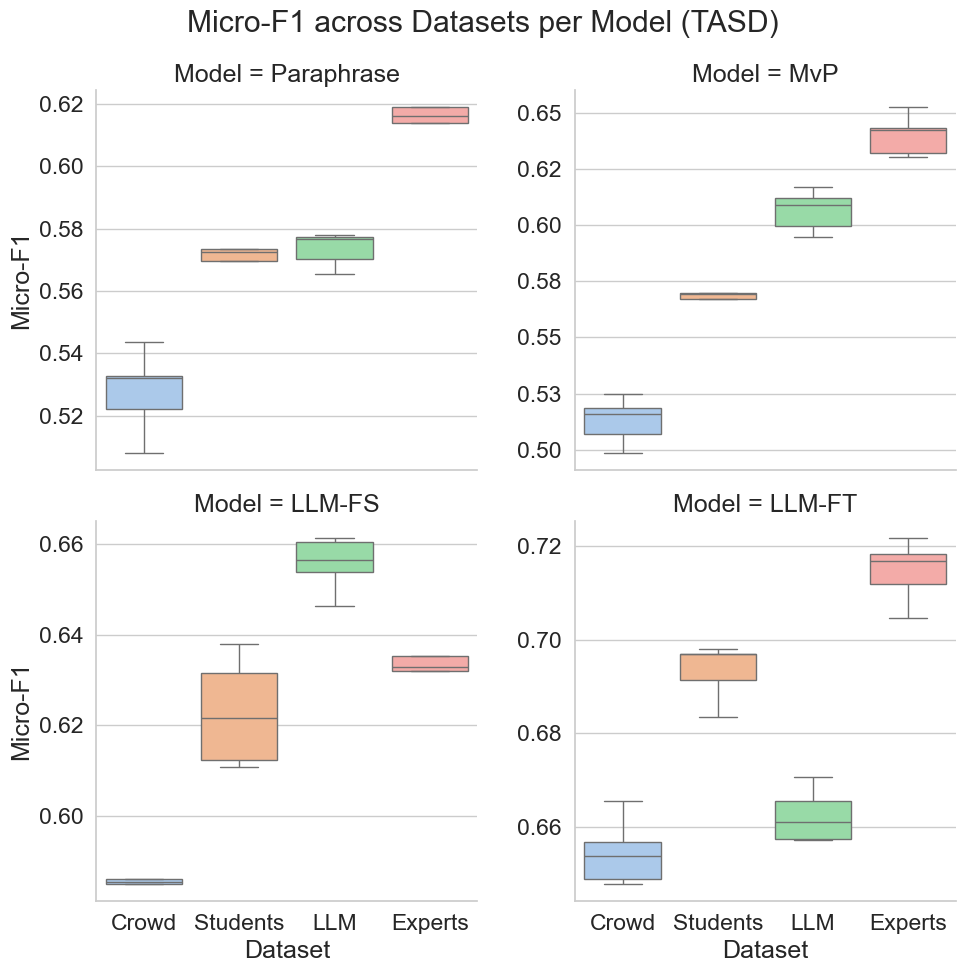

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Load Excel
task = "tasd"
file_path = f"../../12_results/summary/{task}.xlsx"
df = pd.read_excel(file_path)
metric = "Micro-F1"
dataset_order = ["Crowd", "Students", "LLM", "Experts"]
sns.set_theme(style="whitegrid", font_scale=1.5)
# Option 1: Use FacetGrid / catplot (automatic faceting)
g = sns.catplot(
    data=df,
    x="Dataset",
    y=metric,
    col="Model",
    kind="box",
    order=dataset_order,
    col_wrap=2,        # 2 plots per row
    showfliers=False,
    sharey=False,      # allow different y-axes
    palette="pastel"
)

  # example range
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

plt.subplots_adjust(top=0.9)
plt.suptitle(f"{metric} across Datasets per Model ({task.upper()})")
plt.savefig(f"micro_f1_per_model_across_datasets_{task}.pdf", bbox_inches="tight")
plt.show()